In [4]:

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

import os
import numpy as np


data_dir = '/kaggle/input/flower-dataset/dataset'

classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
counts = {c: len([f for f in os.listdir(os.path.join(data_dir, c)) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.gif'))]) for c in classes}

print('Number of classes:', len(classes))
for c in classes:
    print(f'{c}: {counts[c]} images')

Number of classes: 5
daisy: 501 images
dandelion: 646 images
roses: 497 images
sunflowers: 495 images
tulips: 607 images


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
num_classes = len(classes)

In [7]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

valtest_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

valtest_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
test_batches = valtest_batches // 3
test_ds = valtest_ds.take(test_batches)
val_ds = valtest_ds.skip(test_batches)


Found 2746 files belonging to 5 classes.
Using 1923 files for training.


I0000 00:00:1762880552.915347      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762880552.916012      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2746 files belonging to 5 classes.
Using 823 files for validation.


In [8]:
# ( augmentations + normalization)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])


rescale = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


In [9]:
def plot_metrics(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.show()

In [10]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',          
        patience=5,                  
        restore_best_weights=True    
    ),
    ModelCheckpoint(
        filepath="best_weights_{epoch:02d}_{val_accuracy:.2f}.keras", 
        monitor='val_accuracy',      
        save_best_only=True,         
        mode='max',                  
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',         
        factor=0.2,                  
        patience=3,                 
        min_lr=1e-6,               
        verbose=1
    )
]

In [11]:
#  ALEXNET 
model_alex = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_alex.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history_alex = model_alex.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


I0000 00:00:1762880583.531633     124 service.cc:148] XLA service 0x791568004940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762880583.532447     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762880583.532472     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762880583.935988     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/61 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2257 - loss: 1.6135

I0000 00:00:1762880589.264378     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2784 - loss: 1.5369
Epoch 1: val_accuracy improved from -inf to 0.41975, saving model to best_weights_01_0.42.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step - accuracy: 0.2792 - loss: 1.5356 - val_accuracy: 0.4198 - val_loss: 1.3421 - learning_rate: 1.0000e-04
Epoch 2/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.4719 - loss: 1.2068
Epoch 2: val_accuracy improved from 0.41975 to 0.55908, saving model to best_weights_02_0.56.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 376ms/step - accuracy: 0.4725 - loss: 1.2058 - val_accuracy: 0.5591 - val_loss: 1.0349 - learning_rate: 1.0000e-04
Epoch 3/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.5388 - loss: 1.0801
Epoch 3: val_accuracy improved from 0.55908 to 0.58025, saving model to best_weights_03_0.58.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 379ms/step - accuracy: 0.5386 - loss: 1.0808 - val_accuracy: 0.5802 - val_loss: 1.0403 - learning_rate: 1.0000e-04
Epoch 4/30
60/61 ━━━━

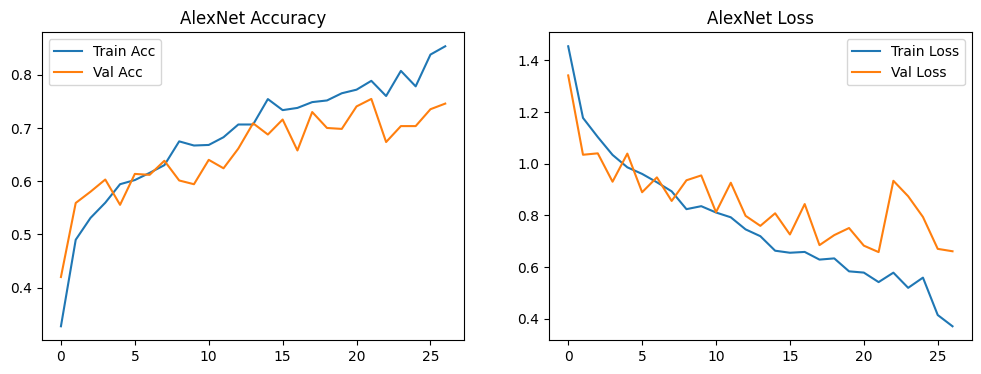

In [12]:
plot_metrics(history_alex, "AlexNet")

In [13]:
test_loss, test_acc = model_alex.evaluate(test_ds)

print(f"AlexNet Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7731 - loss: 0.6866
AlexNet Test Accuracy: 75.00%


In [14]:
# ---------- VGG16 ----------
model_vgg16 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg16.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

history_vgg16 = model_vgg16.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.2373 - loss: 1.5913
Epoch 1: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2376 - loss: 1.5912 - val_accuracy: 0.2522 - val_loss: 1.6031 - learning_rate: 1.0000e-04
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.2274 - loss: 1.6061
Epoch 2: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 585ms/step - accuracy: 0.2276 - loss: 1.6059 - val_accuracy: 0.3457 - val_loss: 1.8559 - learning_rate: 1.0000e-04
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.3244 - loss: 1.4962
Epoch 3: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.3250 - loss: 1.4950 - val_accuracy: 0.4215 - val_loss: 1.3646 - learning_rate: 1.0000e-04
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.3510 - loss: 1.3551
Epoch 4: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━

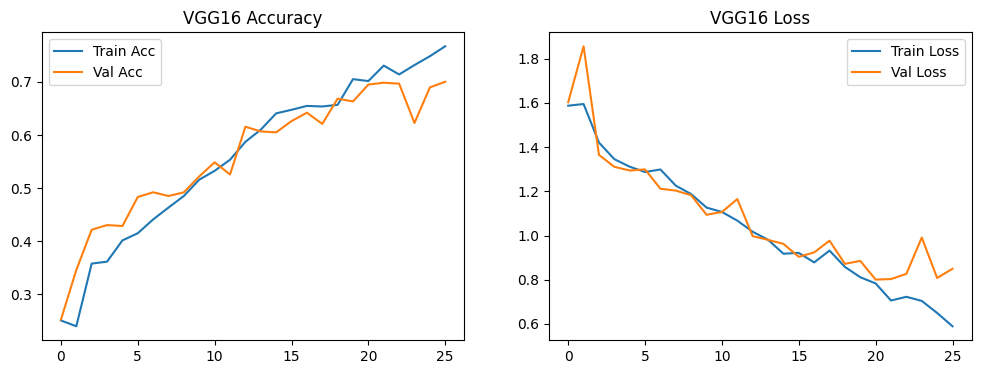

In [15]:
plot_metrics(history_vgg16, "VGG16")


In [16]:
test_loss, test_acc = model_vgg16.evaluate(test_ds)
print(f"VGG16 Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6768 - loss: 0.7639
VGG16 Test Accuracy: 65.62%


In [19]:
# ---------- VGG19 ----------
model_vgg19 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg19.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


history_vgg19 = model_vgg19.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)


Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_48/1082354217.py", line 48, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 5349820352 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_90239]

In [ ]:
plot_metrics(history_vgg19, "VGG19")


In [ ]:
test_loss, test_acc = model_vgg19.evaluate(test_ds)
print(f"VGG19 Test Accuracy: {test_acc*100:.2f}%")